In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.functional as F

from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

from datetime import datetime
from model_util import count_parameters
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import load_img_tensor, show_img_tensor_CHW
from pathlib import Path


/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Multi-label image Dataset and DataLoader
 -  https://www.kaggle.com/datasets/meherunnesashraboni/multi-label-image-classification-dataset?resource=download 

In [2]:
device = torch.device("mps")


In [3]:
class MultiLabelImgClassifierConfig:
    root_dir = Path("/Users/chengbai/ml/dataset/multilabel_modified")

    img_classes = 16

    img_h_size = 512
    img_w_size = 512

    batch_size = 20

    # Transfomer    
    img_patch_size = 16
    img_patches = (img_w_size // img_patch_size) * (img_h_size // img_patch_size)
    img_patch_embedding = 728

    # Img Transform
    img_hidden = 1024
    img_transformer_heads = 8
    img_dropout = 0.0
    img_transformer_blocks = 6


class MultiLabelImgeDataset(Dataset):
    def __init__(self, config: MultiLabelImgClassifierConfig, split: str = "TRAIN", train_eval_test_split = (0.9*0.8, 0.9*0.2, 0.1)):
        super().__init__()
        self.config  = config
        self.df = pd.read_csv(config.root_dir/"multilabel_classification(cheng).csv")
        self.split = split
        self.train_eval_test_split = train_eval_test_split 
        train_split_index = int(len(self.df)*train_eval_test_split[0]) 
        eval_split_index = int(len(self.df)*(train_eval_test_split[0]+train_eval_test_split[1])) 
        if split == "TRAIN":
            self.df = self.df[:train_split_index]
        elif split == "EVAL":
            self.df = self.df[train_split_index:eval_split_index]
        else:
            # TEST split
            self.df = self.df[eval_split_index:]

        self.labels = list(self.df.columns[2:])
        assert len(self.labels) == config.img_classes
        
        self.id_2_label = {i:label  for i, label in enumerate(self.labels)}
        self.label_2_id = {label:i  for i, label in enumerate(self.labels)}

    def _local_cache(self) -> Path:
        return  self.config.root_dir/"cache"
    
    def __len__(self):
        return len(self.df)
    
    def get_item_img_file(self, index:int)->str:
        index = index % len(self)
        item = self.df.iloc[index]
        img_file_path = self.config.root_dir / "images"/ item[0]
        return img_file_path
    
    def __getitem__(self, index: int):
        index = index % len(self)
    
        # check cache first
        if (self._local_cache()/f"img_tensor_{index}.pt").is_file() and (self._local_cache()/f"label_tensor_{index}.pt").is_file():
            img_tensor = torch.load(self._local_cache()/f"img_tensor_{index}.pt")
            label_tensor = torch.load(self._local_cache()/f"label_tensor_{index}.pt")
        else:
            item = self.df.iloc[index]
            img_file_path = self.config.root_dir / "images"/ item[0]
            img_tensor = load_img_tensor(config=self.config, img_file_path=img_file_path)
            label_tensor = torch.tensor(item[2:], dtype=torch.int)
        return img_tensor, label_tensor
    
    def id_to_label(self, label_id: int)->str:
        assert label_id in self.id_2_label
        return self.id_2_label[label_id]
    

    def label_to_id(self, label: str)->int:
        assert label in self.label_2_id
        return self.label_2_id[label]

    def cache_data(self):
        for idx, tensor in enumerate(self):
            img_tensor, label_tensor  = tensor
            torch.save(img_tensor, f"{self.config.root_dir}/cache/img_tensor_{idx}.pt")
            torch.save(label_tensor, f"{self.config.root_dir}/cache/label_tensor_{idx}.pt")

In [4]:
config = MultiLabelImgClassifierConfig()
train_dataset = MultiLabelImgeDataset(config=config, split="TRAIN")
eval_dataset = MultiLabelImgeDataset(config=config, split="EVAL")
test_dataset = MultiLabelImgeDataset(config=config, split="TEST")
print(f"train_dataset: {len(train_dataset)}")
print(f"eval_dataset: {len(eval_dataset)}")
print(f"test_dataset: {len(test_dataset)}")
# print(train_dataset[0])

train_data_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
eval_data_loader = DataLoader(dataset=eval_dataset, batch_size=config.batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True)

train_dataset: 5646
eval_dataset: 1412
test_dataset: 785


In [5]:
def viz_img_label_pred(dataset: MultiLabelImgeDataset, img_tensor: torch.tensor, target_tensor: torch.tensor, prediction: torch.tensor=None):
    img_tensor = img_tensor.cpu()
    target_tensor = target_tensor.cpu()
    if prediction is not None:
        prediction = prediction.cpu()

    print(img_tensor.size())
    print(target_tensor)
    show_img_tensor_CHW(img_tensor=img_tensor)
    print(f"target: {[dataset.id_to_label(i) for i, t in enumerate(target_tensor) if t]}")
    if prediction:
        print(prediction)
        print(f"prediction: {[dataset.id_2_label[i] for i, p in enumerate(prediction) if p]}")
    

img_file: /Users/chengbai/ml/dataset/multilabel_modified/images/image7059.jpg
torch.Size([3, 512, 512])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
target: ['desert']


/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_file_path = self.config.root_dir / "images"/ item[0]
/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_tensor = torch.tensor(item[2:], dtype=torch.int)
/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

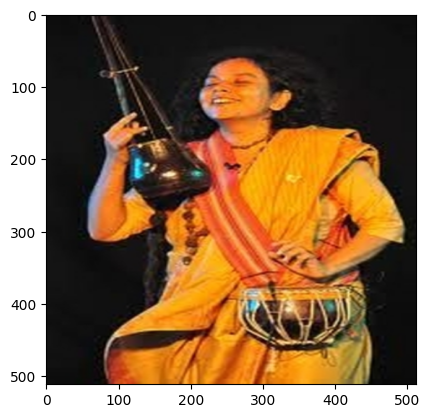

In [6]:
for i in range(len(test_dataset)):
    img_tensor, target_tensor = test_dataset[i]
    img_file = test_dataset.get_item_img_file(i)
    print(f"img_file: {img_file}")
    viz_img_label_pred(dataset=test_dataset, img_tensor=img_tensor, target_tensor=target_tensor)
    break

In [7]:
data = next(iter(train_data_loader))
batch_img_tensor, batch_label = data
print(f"batch_img_tensor: {batch_img_tensor.size()}")
print(f"batch_label: {batch_label.size()}")

/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_file_path = self.config.root_dir / "images"/ item[0]
/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_tensor = torch.tensor(item[2:], dtype=torch.int)


batch_img_tensor: torch.Size([20, 3, 512, 512])
batch_label: torch.Size([20, 16])


# Multi-Label Image Classifier Model

In [8]:
class MultiLabelImgClassifier(nn.Module):
    def __init__(self, config: MultiLabelImgClassifierConfig):
        super().__init__()
        assert config is not None
        self.config = config
        self.img_embedding = ImageEmbedding(config=config)
        self.img_transf = ImgTransformer(config=config)
        self.dropout = nn.Dropout(config.img_dropout)
        self.layer_norm1 = nn.LayerNorm(config.img_hidden)
        self.linear1 = nn.Linear(config.img_patches*config.img_patch_embedding, config.img_hidden, bias=True)
        self.linear2 = nn.Linear(config.img_hidden, config.img_classes, bias=True)
        self.act = nn.SiLU()
        self.sig = nn.Sigmoid()

    def forward(self, batch_img_tensor: torch.tensor, batch_target_tensor: torch.tensor = None):
        """
        batch_img_tensor: B x H x W
        batch_target_tensor: B x 16
        """
        batch_img_tensor = self.img_embedding(batch_img_tensor) # B x IMG_PATCHES x IMG_EMB
        B, IMG_PATCHES, IMG_EMB  = batch_img_tensor.size()
        assert IMG_PATCHES == self.config.img_patches
        assert IMG_EMB == self.config.img_patch_embedding

        batch_img_tensor = self.img_transf(batch_img_tensor) # B x IMG_PATCHES x IMG_EMB
        assert batch_img_tensor.size() == (B, IMG_PATCHES, IMG_EMB)
        batch_img_tensor = batch_img_tensor.contiguous().view(B, -1)

        batch_img_tensor = self.act(self.linear1(batch_img_tensor))  # B x IMG_PATCHES x IMG_HIDDEN
        batch_img_tensor = self.dropout(batch_img_tensor)
        batch_img_tensor = self.layer_norm1(batch_img_tensor)
        pred = self.linear2(batch_img_tensor) # B x IMG_PATCHES x IMG_CLASSES

        # multi-label probability
        prob = self.sig(pred) # # B x IMG_PATCHES x IMG_EMB
        assert prob.size() == (B, self.config.img_classes), f"Expect prob has size: {(B, self.config.img_classes)}, but get {prob.size()}"

        # loss
        loss = None
        if batch_target_tensor is not None:
            loss = torch.where(batch_target_tensor==1.0, -torch.log(prob), -torch.log(1-prob))
            loss = loss.mean()
        return prob > 0.5, loss



In [9]:
model = MultiLabelImgClassifier(config=config)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"pytorch_total_params: {pytorch_total_params/10**6} m")
print(f"pytorch_total_trainable_params: {pytorch_total_trainable_params/10**6} m")
count_parameters(model)


pytorch_total_params: 777.442664 m
pytorch_total_trainable_params: 777.442664 m
+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|              img_embedding.conv.weight              |   559104   |
|               img_embedding.conv.bias               |    728     |
|          img_embedding.pos_embedding.weight         |   745472   |
|  img_transf.blocks.0.multihead_attention.wq.weight  |   529984   |
|   img_transf.blocks.0.multihead_attention.wq.bias   |    728     |
|  img_transf.blocks.0.multihead_attention.wk.weight  |   529984   |
|   img_transf.blocks.0.multihead_attention.wk.bias   |    728     |
|  img_transf.blocks.0.multihead_attention.wv.weight  |   529984   |
|   img_transf.blocks.0.multihead_attention.wv.bias   |    728     |
| img_transf.blocks.0.multihead_attention.norm.weight |    728     |
|  img_transf.blocks.0.

777442664

In [10]:
EPOCHES = 3
EVAL_INTERVAL = 50
EVAL_STEPS = 10
lr = 0.001

model = model.to(device)
optimizer = AdamW(params=model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_data_loader), epochs=EPOCHES)

def eval(model: MultiLabelImgClassifier, train_step : int, writer: SummaryWriter):
    model.eval()

    avg_eval_loss = None
    eval_loss_std = None
    with torch.no_grad():
        eval_losses = []
        for i, data in enumerate(eval_data_loader):
            if i > EVAL_STEPS:
                # It takes significant time to do one full eval.
                break

            batch_img_tensor, batch_target_tensor = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_target_tensor = batch_target_tensor.to(device)
            _, loss = model(batch_img_tensor, batch_target_tensor)
            eval_losses.append(loss)
        eval_losses = torch.tensor(eval_losses)
        avg_eval_loss = eval_losses.mean()
        eval_loss_std = eval_losses.std()
        writer.add_scalar("Loss/eval", avg_eval_loss, train_step)
        writer.add_scalar("Loss/eval-std", eval_loss_std, train_step)
    model.train()
    writer.flush()
    return avg_eval_loss, eval_loss_std
    


def train(model: MultiLabelImgClassifier, writer: SummaryWriter):
    best_vloss = torch.tensor(1_000_000)
    for epoch in range(EPOCHES): 
        for train_step, data in enumerate(train_data_loader):
            batch_img_tensor, batch_target_tensor = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_target_tensor = batch_target_tensor.to(device)
            optimizer.zero_grad()
            pred, loss = model(batch_img_tensor, batch_target_tensor)
            writer.add_scalar("Learning Rate", scheduler.get_last_lr()[-1], epoch * len(train_data_loader) + train_step)
            writer.add_scalar("Loss/train", loss, epoch * len(train_data_loader) + train_step)
            loss.backward()
            optimizer.step()
            scheduler.step()

            if train_step > 0 and train_step % EVAL_INTERVAL == 0:
                avg_vloss, _ = eval(model=model, train_step= epoch * len(train_data_loader) + train_step, writer=writer)
            
                if avg_vloss is not None and avg_vloss < best_vloss:
                    best_vloss = avg_vloss
                    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                    model_path = f"multi_label_img_classifier_{epoch}_{timestamp}"
                    torch.save(model.state_dict(), model_path)

with SummaryWriter(flush_secs=1) as writer:
    train(model=model, writer=writer)

/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_file_path = self.config.root_dir / "images"/ item[0]
/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_8368/3359347179.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_tensor = torch.tensor(item[2:], dtype=torch.int)


In [ ]:
model_path = f"multi_label_img_classifier_try1_final"
torch.save(model.state_dict(), model_path)

/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_77079/3404758477.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_file_path = self.config.root_dir / "images"/ item[0]
/var/folders/46/4yv_0b8n161097gg93qqvb6w0000gn/T/ipykernel_77079/3404758477.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_tensor = torch.tensor(item[2:], dtype=torch.int)


torch.Size([3, 512, 512])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
label: ['sea']
prediction: []


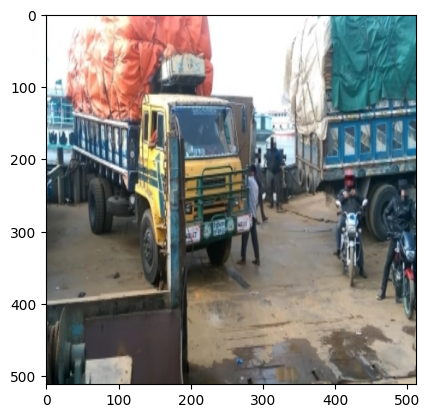

In [ ]:
with torch.no_grad():
    model.eval()
    for test_step, data in enumerate(test_data_loader):
        batch_img_tensor, batch_target_tensor = data
        batch_img_tensor = batch_img_tensor.to(device)
        batch_target_tensor = batch_target_tensor.to(device)

        test_pred, test_loss = model(batch_img_tensor, batch_target_tensor)

        for img_tensor, target_tensor, pred in zip(batch_img_tensor, batch_target_tensor, test_pred):
            img_tensor, target_tensor, pred = img_tensor.cpu(), target_tensor.cpu(), pred.cpu()
            print(img_tensor.size())
            print(pred)
            print(target_tensor)
            show_img_tensor_CHW(img_tensor=img_tensor.cpu())
            print(f"label: {[test_dataset.id_2_label[i] for i, t in enumerate(target_tensor) if t]}")
            print(f"prediction: {[test_dataset.id_2_label[i] for i, p in enumerate(pred) if p]}")
            break
            

        break
    model.train()


In [ ]:
test_pred.size(), test_loss, batch_img_tensor.size(), batch_target_tensor.size()

(torch.Size([20, 16]),
 tensor(0.6712, device='mps:0'),
 torch.Size([20, 3, 512, 512]),
 torch.Size([20, 16]))

torch.Size([3, 512, 512])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
label: ['desert']
prediction: []


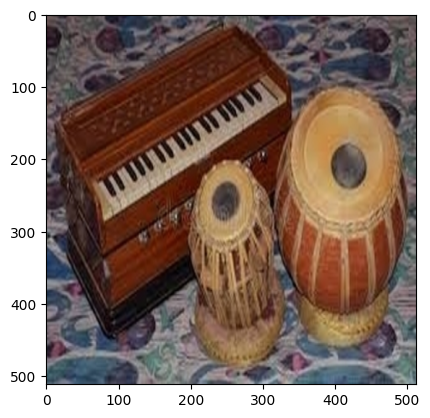

In [ ]:
test_dataset.id_2_label

{0: 'motorcycle',
 1: 'truck',
 2: 'boat',
 3: 'bus',
 4: 'cycle',
 5: 'person',
 6: 'desert',
 7: 'mountains',
 8: 'sea',
 9: 'sunset',
 10: 'trees',
 11: 'sitar',
 12: 'ektara',
 13: 'flutes',
 14: 'tabla',
 15: 'harmonium'}